# Gradient Descent

Ce notebook contient du code qui permet de visualiser les étapes de différents algorithmes gradient descent. Il dépend de certaines librairies externes:

Dependances:
- matplotlib >=3.0.0
- ipyvolume
- autograd

# Utilities

In [1]:
import ipyvolume as ipv
import autograd.numpy as np
import matplotlib
from matplotlib import cm
from scipy import optimize

from autograd import grad, value_and_grad
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(matplotlib.__version__)

3.0.0


# Loss Functions

Définition d'une fonction z = f(__x__) où **x** est un vecteur. 

In [3]:
def quad_func(x, W=[[1,0],[0,1]]):
    '''Définiton de fonction quadratique.
    
    W: matrice 2x2
    x: ndarray() ou np.meshgrid()
    
    '''
    u, v = x
    z = u**2*W[0][0]+u*v*W[1][0]+v*u*W[0][1]+v**2*W[1][1]
    return z

In [4]:
def sinus_func(x):
    u, v = x
    return np.sin((u+v)) + (u-v)**2 - 1.5*u + 2.5*v + 1

In [5]:
def jeremy_func(x): # Erreur avec la visualisation 3D
    u, v = x
    return u**2 + 2*u**2*v**2 + 5*v**2

# Optimizer steps

In [6]:
class Optimizer():
    '''Parent class for optimizers.'''
    def __init__(self, lr):
        self.lr = lr
    
    def step(self, x, dx):
        raise NotImplementedError('Step method not implemented!')

In [7]:
class GradientDescent(Optimizer):
    '''Implementation of gradient descent algorithm.'''
    def __init__(self, lr):
        Optimizer.__init__(self, lr)
        
        
    def step(self, x, dx):
        x = x - self.lr*dx
        return x

In [8]:
class NoisyGradientDescent(Optimizer):
    '''Implementation of gradient descent algorithm with random gaussian noise.'''
    def __init__(self, lr, noise):
        Optimizer.__init__(self, lr)
        self.noise = noise
        
        
    def step(self, x, dx):
        x = x - self.lr*dx + np.random.normal(0, self.noise, size=x.shape)
        return x

In [9]:
class GradientDescentMomentum(Optimizer):
    '''Implementation of gradient descent algorithm with momentum.'''
    def __init__(self, lr, mom):
        Optimizer.__init__(self, lr)
        self.mom = mom
        self.v = None
        
        
    def step(self, x, dx):
        if self.v is None:
            self.v = self.lr*dx
        else:
            self.v = self.mom*self.v + self.lr*dx
        x = x - self.v
        return x

# Hyperparameters

In [13]:
# Quadratic function coefficients
W = [[2,0],
     [0,1]]
print("Eigenvalues of W: ")
print(np.linalg.eig(W))

# Define loss function
my_func = lambda x : quad_func(x, W)

# activate the optimizer calculation, set to False to skip optimizer calculations
optim_flag = True

# Optimizer parameters
# Uncomment desired optimizer

#optimizer = Optimizer(lr=0.1)
#optimizer = GradientDescent(lr=0.1)
#optimizer = NoisyGradientDescent(lr=0.1, noise=0.1)
optimizer = GradientDescentMomentum(lr=0.01, mom=0.95)

# number of iterations for optimizer
N_ITER = 100

# Set initial point
x0 = np.asarray((18,18), dtype='float64') 

# Visualization parameters
xlim = ylim = 20.1
zlim = 300
N_LEVELS = 10

Eigenvalues of W: 
(array([2., 1.]), array([[1., 0.],
       [0., 1.]]))


In [14]:
def optim_aux(func, optimizer, x, niterations=15, **kwargs):
    '''Perform optimization calculation based on optimizer.
    
    Inputs:
    
    func: a numerical function defined such that Z = f(x) where x is a vector. 
    optimizer: Child of the Optimizer() class with a defined step method
    x: initial starting point for gradient descent
    niterations: max iterations that the network can do
    
    Outputs:
    
    path: ndarray() containing the x,y,z path of gradient descent
    
    '''
    z, gradf = func(x)
    
    # Contains all intermediate results of optimization iteration
    path = [x]
    zz = [z]
    
    ii = 0
    while ii < niterations and z > -zlim:
        
        x = optimizer.step(x, gradf)
        z, gradf = func(x)

        path.append(x)
        zz.append(z)
        ii+=1

    zz = np.expand_dims(np.asarray(zz), axis=1)
    path = np.vstack(path)
    path = np.hstack([path, zz])
    
    return path

# Visualization

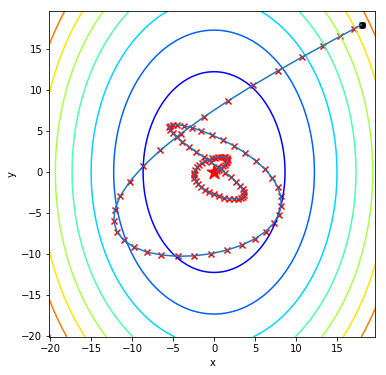

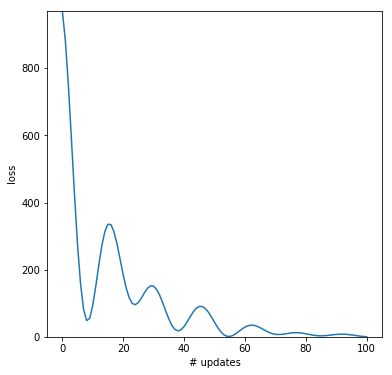

In [16]:
# Initialize meshgrid
dx = dy = 2*xlim/100

X = np.arange(-xlim, xlim, dx)
Y = np.arange(-ylim, ylim, dy)
x = np.meshgrid(X, Y)

# Compute function over the entire meshgrid
X, Y = x
Z = my_func(x)

# Define colormap for ipv visualization
colormap = cm.jet
color = colormap(((Z-np.min(Z)))/np.max(Z))

# 3D plot
fig = ipv.figure()
ipv.pylab.style.axes_off()
ipv.pylab.xyzlabel('', '', '')
ipv.plot_mesh(X, Y, Z, color=color[...,:3])

# 2D Contour plot
plt.figure(figsize=(6,6))
plt.contour(X, Y, Z, levels=N_LEVELS, cmap=plt.cm.jet)

plt.axis([-xlim, xlim, -ylim, ylim])
plt.xlim((-xlim, xlim))
plt.ylim((-ylim, ylim))
plt.axis('square')

plt.xlabel('x')
plt.ylabel('y')

if optim_flag:
    
    # Perform optimization
    func = value_and_grad(my_func)
    path = optim_aux(func, optimizer, x0, niterations=N_ITER)
    
    # Plot 3D path
    s = ipv.scatter(path[:, None, 0], path[:, None, 1], path[:, None,2], size=5, color='white', marker="sphere") # path[:,None, 0]: to keep the dimension
    ipv.plot(path[:,0], path[:,1], path[:,2], color='white', linewidth=100000)
    ipv.animation_control(s)
    
    # Plot 2D path
    plt.scatter(path[0:-1,0], path[0:-1,1], marker="x", color='red')
    plt.scatter(path[0,0], path[0,1], marker="o", color='black')
    plt.scatter(path[-1,0], path[-1,1], marker="x", color='red')
    plt.scatter(0, 0, marker="*", s=250, color='red')
    plt.plot(path[:,0], path[:,1])
    
    # Plot the 2D loss function
    plt.figure(figsize=(6,6))
    plt.plot(path[:,2])
    plt.ylim([0, max(path[:,2])])
    plt.xlabel('# updates')
    plt.ylabel('loss')

ipv.view(azimuth=50, distance=0, elevation=100)
    
ipv.show()
plt.show()

